# Getting started with CmdStanR

Authors: Jonah Gabry and Rok Češnovar

(Jupyter notebook edited by Pål K. B. Bjartan)




## Introduction

CmdStanR (Command Stan R) is a lightweight interface to
[Stan](https://mc-stan.org/) for R users that provides an alternative to the
traditional [RStan](https://mc-stan.org/rstan/) interface. See the [*Comparison
with RStan*](#comparison-with-rstan) section later in this vignette for more
details on how the two interfaces differ.

**CmdStanR is not on CRAN yet**, but the beta release can be installed by
running the following command in R.

In [ ]:
# we recommend running this is a fresh R session or restarting your current session
# install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

CmdStanR (the **cmdstanr** R package) can now be loaded like any other R
package. We'll also load the **bayesplot** and **posterior** packages to use
later in examples.

In [1]:
library(cmdstanr)
library(posterior)
library(bayesplot)
color_scheme_set("brightblue")

This is cmdstanr version 0.6.0

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /opt/cmdstan/cmdstan-2.32.2

- CmdStan version: 2.32.2

This is posterior version 1.4.1


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘bayesplot’


The following object is masked from ‘package:posterior’:

    rhat




## Installing CmdStan

CmdStanR requires a working installation of
[CmdStan](https://mc-stan.org/users/interfaces/cmdstan.html), the shell
interface to Stan. If you don't have CmdStan installed then CmdStanR can install
it for you, assuming you have a suitable C++ toolchain. The requirements are
described in the CmdStan Guide:

* https://mc-stan.org/docs/cmdstan-guide/cmdstan-installation.html

To double check that your toolchain is set up properly you can call
the `check_cmdstan_toolchain()` function:

In [2]:
check_cmdstan_toolchain()

The C++ toolchain required for CmdStan is setup properly!



If your toolchain is configured correctly then CmdStan can be installed by
calling the
[`install_cmdstan()`](https://mc-stan.org/cmdstanr/reference/install_cmdstan.html)
function:

In [ ]:
# install_cmdstan(cores = parallel::detectCores())

Before CmdStanR can be used it needs to know where the CmdStan installation is
located. When the package is loaded it tries to help automate this to avoid
having to manually set the path every session:

1. If the environment variable `"CMDSTAN"` exists at load time then its value
will be automatically set as the default path to CmdStan for the R session. This
is useful if your CmdStan installation is not located in the default directory
that would have been used by `install_cmdstan()` (see #2).

2. If no environment variable is found when loaded but any directory in the form
`".cmdstan/cmdstan-[version]"`, for example `".cmdstan/cmdstan-2.23.0"`,
exists in the user's home directory (`Sys.getenv("HOME")`,
*not* the current working directory) then the path to the CmdStan with the
largest version number will be set as the path to CmdStan for the R session.
This is the same as the default directory that `install_cmdstan()` uses to
install the latest version of CmdStan, so if that's how you installed CmdStan
you shouldn't need to manually set the path to CmdStan when loading CmdStanR.

If neither of these applies (or you want to subsequently change the path) you
can use the `set_cmdstan_path()` function:

In [ ]:
# set_cmdstan_path(PATH_TO_CMDSTAN)

To check the path to the CmdStan installation and the CmdStan version number
you can use `cmdstan_path()` and `cmdstan_version()`:

In [3]:
cmdstan_path()
cmdstan_version()

[1] "/opt/cmdstan/cmdstan-2.32.2"

[1] "2.32.2"

## Compiling a model

The `cmdstan_model()` function creates a new
[`CmdStanModel`](https://mc-stan.org/cmdstanr/reference/CmdStanModel.html)
object from a file containing a Stan program. Under the hood, CmdStan is called
to translate a Stan program to C++ and create a compiled executable. Here we'll
use the example Stan program that comes with the CmdStan installation:

In [8]:
file <- file.path(cmdstan_path(), "examples", "bernoulli", "bernoulli.stan")
mod <- cmdstan_model(file, force_recompile = TRUE)

The object `mod` is an [R6](https://r6.r-lib.org/) reference object of class
[`CmdStanModel`](https://mc-stan.org/cmdstanr/reference/CmdStanModel.html) and
behaves similarly to R's reference class objects and those in object oriented
programming languages. Methods are accessed using the `$` operator. This design
choice allows for CmdStanR and
[CmdStanPy](https://github.com/stan-dev/cmdstanpy) to provide a similar user
experience and share many implementation details.

The Stan program can be printed using the `$print()` method:

In [9]:
mod$print()

data {
  int<lower=0> N;
  array[N] int<lower=0,upper=1> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);  // uniform prior on interval 0,1
  y ~ bernoulli(theta);
}


The path to the compiled executable is returned by the `$exe_file()`
method:

In [10]:
mod$exe_file()

[1] "/opt/cmdstan/cmdstan-2.32.2/examples/bernoulli/bernoulli"

## Running MCMC

The
[`$sample()`](https://mc-stan.org/cmdstanr/reference/model-method-sample.html)
method for
[`CmdStanModel`](https://mc-stan.org/cmdstanr/reference/CmdStanModel.html)
objects runs Stan's default MCMC algorithm. The `data` argument accepts a named
list of R objects (like for RStan) or a path to a data file compatible with
CmdStan (JSON or R dump).

In [11]:
# names correspond to the data block in the Stan program
data_list <- list(N = 10, y = c(0,1,0,0,0,0,0,0,0,1))

fit <- mod$sample(
  data = data_list,
  seed = 123,
  chains = 4,
  parallel_chains = parallel::detectCores(),
  refresh = 500 # print update every 500 iters
)

Running MCMC with 4 chains, at most 16 in parallel...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmu

There are many more arguments that can be passed to the `$sample()` method.
For details follow this link to its separate documentation page:

* [`$sample()`](https://mc-stan.org/cmdstanr/reference/model-method-sample.html)

The `$sample()` method creates [R6](https://r6.r-lib.org/) `CmdStanMCMC`
objects, which have many associated methods. Below we will demonstrate some of
the most important methods. For a full list, follow this link to the
`CmdStanMCMC` documentation:

* [`CmdStanMCMC`](https://mc-stan.org/cmdstanr/reference/CmdStanMCMC.html)

### Posterior summary statistics

#### Summaries from the posterior package

The
[`$summary()`](https://mc-stan.org/cmdstanr/reference/fit-method-summary.html)
method calls `summarise_draws()` from the **posterior** package. The
first argument specifies the variables to summarize and any arguments
after that are passed on to `posterior::summarise_draws()` to specify
which summaries to compute, whether to use multiple cores, etc.

In [12]:

fit$summary()
fit$summary(variables = c("theta", "lp__"), "mean", "sd")

# use a formula to summarize arbitrary functions, e.g. Pr(theta <= 0.5)
fit$summary("theta", pr_lt_half = ~ mean(. <= 0.5))

# summarise all variables with default and additional summary measures
fit$summary(
  variables = NULL,
  posterior::default_summary_measures(),
  extra_quantiles = ~posterior::quantile2(., probs = c(.0275, .975))
)

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-7.2635780,-6.9883900,0.7041105,0.3303529,-8.76403150,-6.7503695,1.002142,1951.687,2046.295
theta,0.2499496,0.2338195,0.1193248,0.1212166,0.08211327,0.4643312,1.002803,1552.214,1620.706


variable,mean,sd
<chr>,<dbl>,<dbl>
theta,0.2499496,0.1193248
lp__,-7.2635780,0.7041105


variable,pr_lt_half
<chr>,<dbl>
theta,0.9685


variable,mean,median,sd,mad,q5,q95,q2.75,q97.5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-7.2635780,-6.9883900,0.7041105,0.3303529,-8.76403150,-6.7503695,-9.23174112,-6.7484800
theta,0.2499496,0.2338195,0.1193248,0.1212166,0.08211327,0.4643312,0.06529373,0.5225594


#### CmdStan's stansummary utility

CmdStan itself provides a `stansummary` utility that can be called using the
`$cmdstan_summary()` method. This method will print summaries but won't return
anything.

In [13]:
fit$cmdstan_summary()

Inference for Stan model: bernoulli_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.0010, 0.0010, 0.0010, 0.0010) seconds, 0.0040 seconds total
Sampling took (0.0040, 0.0040, 0.0040, 0.0040) seconds, 0.016 seconds total

                Mean     MCSE  StdDev     5%   50%   95%  N_Eff  N_Eff/s    R_hat

lp__            -7.3  1.7e-02    0.70   -8.8  -7.0  -6.8   1672  1.0e+05      1.0
accept_stat__   0.92  2.1e-03    0.13   0.66  0.97   1.0   3488  2.2e+05  1.0e+00
stepsize__      0.97  6.2e-02   0.088   0.84   1.0   1.1    2.0  1.3e+02  2.7e+13
treedepth__      1.4  8.4e-03    0.49    1.0   1.0   2.0   3412  2.1e+05  1.0e+00
n_leapfrog__     2.6  3.4e-02     1.3    1.0   3.0   3.0   1488  9.3e+04  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00    nan      nan      nan
energy__         7.8  2.5e-02     1.0    6.8   7.5   9.8   1664  1.0e+05  1.0e+00

theta           0.25  3.0e-03    0.12  0.0


### Posterior draws

#### Extracting draws

The [`$draws()`](https://mc-stan.org/cmdstanr/reference/fit-method-draws.html)
method can be used to extract the posterior draws in formats provided by the
[**posterior**](https://mc-stan.org/posterior/) package. Here we demonstrate
only the `draws_array` and `draws_df` formats, but the **posterior** package
supports other useful formats as well.

In [14]:

# default is a 3-D draws_array object from the posterior package
# iterations x chains x variables
draws_arr <- fit$draws() # or format="array"
str(draws_arr)

# draws x variables data frame
draws_df <- fit$draws(format = "df")
str(draws_df)
print(draws_df)

 'draws_array' num [1:1000, 1:4, 1:2] -9.66 -7.58 -6.75 -7 -7.49 ...
 - attr(*, "dimnames")=List of 3
  ..$ iteration: chr [1:1000] "1" "2" "3" "4" ...
  ..$ chain    : chr [1:4] "1" "2" "3" "4"
  ..$ variable : chr [1:2] "lp__" "theta"
draws_df [4,000 × 5] (S3: draws_df/draws/tbl_df/tbl/data.frame)
 $ lp__      : num [1:4000] -9.66 -7.58 -6.75 -7 -7.49 ...
 $ theta     : num [1:4000] 0.593 0.429 0.254 0.169 0.418 ...
 $ .chain    : int [1:4000] 1 1 1 1 1 1 1 1 1 1 ...
 $ .iteration: int [1:4000] 1 2 3 4 5 6 7 8 9 10 ...
 $ .draw     : int [1:4000] 1 2 3 4 5 6 7 8 9 10 ...
# A draws_df: 1000 iterations, 4 chains, and 2 variables
   lp__ theta
1  -9.7  0.59
2  -7.6  0.43
3  -6.7  0.25
4  -7.0  0.17
5  -7.5  0.42
6  -9.2  0.56
7  -7.0  0.17
8  -6.8  0.24
9  -7.8  0.46
10 -7.8  0.46
# ... with 3990 more draws
# ... hidden reserved variables {'.chain', '.iteration', '.draw'}


To convert an existing draws object to a different format use the
`posterior::as_draws_*()` functions.

In [15]:

# this should be identical to draws_df created via draws(format = "df")
draws_df_2 <- as_draws_df(draws_arr)
identical(draws_df, draws_df_2)

[1] TRUE

In general, converting to a different draws format in this way will be slower
than just setting the appropriate format initially in the call to the `$draws()`
method, but in most cases the speed difference will be minor.

#### Plotting draws

Plotting posterior distributions is as easy as passing the object returned by
the `$draws()` method directly to plotting functions in our
[**bayesplot**](https://mc-stan.org/bayesplot/) package.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


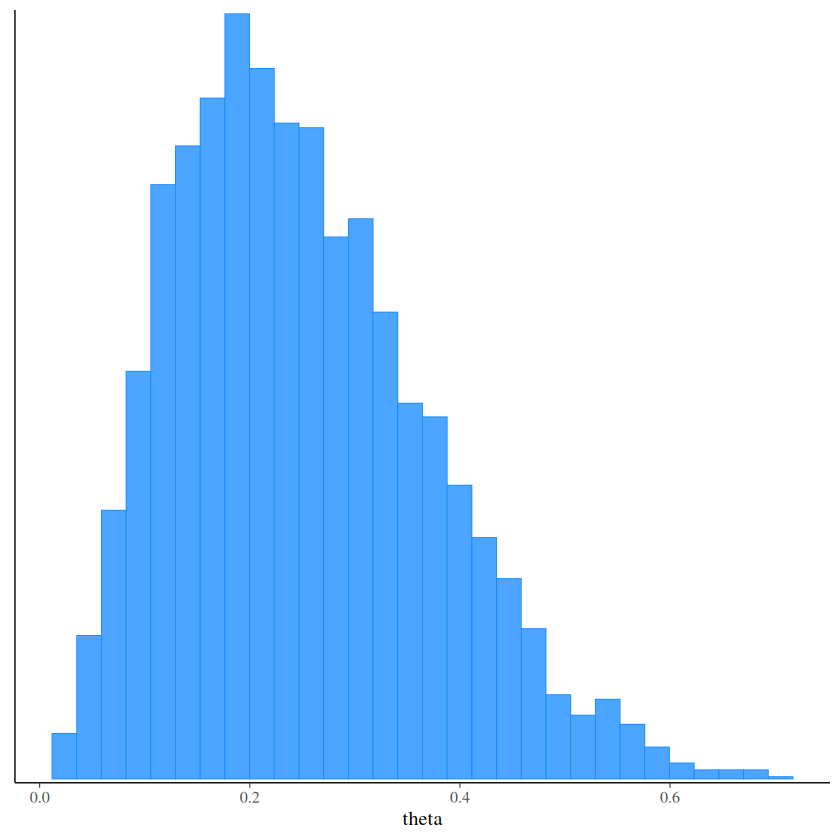

In [16]:
mcmc_hist(fit$draws("theta"))

### Sampler diagnostics

#### Extracting diagnostic values for each iteration and chain

The
[`$sampler_diagnostics()`](https://mc-stan.org/cmdstanr/reference/fit-method-sampler_diagnostics.html)
method extracts the values of the sampler parameters (`treedepth__`,
`divergent__`, etc.) in formats supported by the **posterior** package. The
default is as a 3-D array (iteration x chain x variable).

In [17]:
# this is a draws_array object from the posterior package
str(fit$sampler_diagnostics())

# this is a draws_df object from the posterior package
str(fit$sampler_diagnostics(format = "df"))

 'draws_array' num [1:1000, 1:4, 1:6] 1 1 1 2 1 1 1 1 2 1 ...
 - attr(*, "dimnames")=List of 3
  ..$ iteration: chr [1:1000] "1" "2" "3" "4" ...
  ..$ chain    : chr [1:4] "1" "2" "3" "4"
  ..$ variable : chr [1:6] "treedepth__" "divergent__" "energy__" "accept_stat__" ...
draws_df [4,000 × 9] (S3: draws_df/draws/tbl_df/tbl/data.frame)
 $ treedepth__  : num [1:4000] 1 1 1 2 1 1 1 1 2 1 ...
 $ divergent__  : num [1:4000] 0 0 0 0 0 0 0 0 0 0 ...
 $ energy__     : num [1:4000] 10.27 9.02 7.4 8.02 8.07 ...
 $ accept_stat__: num [1:4000] 0.538 1 1 0.772 0.872 ...
 $ stepsize__   : num [1:4000] 1.05 1.05 1.05 1.05 1.05 ...
 $ n_leapfrog__ : num [1:4000] 3 1 3 3 3 1 3 3 3 1 ...
 $ .chain       : int [1:4000] 1 1 1 1 1 1 1 1 1 1 ...
 $ .iteration   : int [1:4000] 1 2 3 4 5 6 7 8 9 10 ...
 $ .draw        : int [1:4000] 1 2 3 4 5 6 7 8 9 10 ...


#### Sampler diagnostic warnings and summaries

The `$diagnostic_summary()` method will display any sampler diagnostic warnings and return a summary of diagnostics for each chain.

In [18]:
fit$diagnostic_summary()

$num_divergent
[1] 0 0 0 0

$num_max_treedepth
[1] 0 0 0 0

$ebfmi
[1] 1.043908 1.132605 1.078615 1.317367

We see the number of divergences for each of the four chains, the number
of times the maximum treedepth was hit for each chain, and the E-BFMI
for each chain.

In this case there were no warnings, so in order to demonstrate the warning
messages we'll use one of the CmdStanR example models that suffers from
divergences.

In [19]:
fit_with_warning <- cmdstanr_example("schools")

See https://mc-stan.org/misc/warnings for details.




After fitting there is a warning about divergences. We can also regenerate this warning message later using `fit$diagnostic_summary()`.

In [20]:
diagnostics <- fit_with_warning$diagnostic_summary()
print(diagnostics)

# number of divergences reported in warning is the sum of the per chain values
sum(diagnostics$num_divergent)

See https://mc-stan.org/misc/warnings for details.




$num_divergent
[1]  21 371  11  24

$num_max_treedepth
[1] 0 0 0 0

$ebfmi
[1] 0.3559253 0.2387769 0.4147694 0.3799135



[1] 427

#### CmdStan's diagnose utility

CmdStan itself provides a `diagnose` utility that can be called using
the `$cmdstan_diagnose()` method. This method will print warnings but won't return anything.


### Create a `stanfit` object

If you have RStan installed then it is also possible to create a `stanfit`
object from the csv output files written by CmdStan. This can be done by using
`rstan::read_stan_csv()` in combination with the `$output_files()` method of the
`CmdStanMCMC` object. This is only needed if you want to fit a model with
CmdStanR but already have a lot of post-processing code that assumes a `stanfit`
object. Otherwise we recommend using the post-processing functionality provided
by CmdStanR itself.

In [22]:
stanfit <- rstan::read_stan_csv(fit$output_files())
stanfit

Inference for Stan model: bernoulli-202308260026-1-343229.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
theta  0.25    0.00 0.12  0.06  0.16  0.23  0.33  0.52  1616    1
lp__  -7.26    0.02 0.70 -9.31 -7.44 -6.99 -6.80 -6.75  1671    1

Samples were drawn using NUTS(diag_e) at lø. aug. 26 kl. 00.26 +0200 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## Running optimization and variational inference

CmdStanR also supports running Stan's optimization algorithms and its algorithms
for variational approximation of full Bayesian inference. These are run via the
`$optimize()` and `$variational()` methods, which are called in a similar way to
the `$sample()` method demonstrated above.

### Optimization

We can find the (penalized) maximum likelihood estimate (MLE) using [`$optimize()`](https://mc-stan.org/cmdstanr/reference/model-method-optimize.html).

In [23]:
fit_mle <- mod$optimize(data = data_list, seed = 123)
fit_mle$summary() # includes lp__ (log prob calculated by Stan program)
fit_mle$mle("theta")

Initial log joint probability = -9.51104 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes  
       6      -5.00402   0.000103557   2.55661e-07           1           1        9    
Optimization terminated normally:  
  Convergence detected: relative gradient magnitude is below tolerance 
Finished in  0.2 seconds.


variable,estimate
<chr>,<dbl>
lp__,-5.00402
theta,0.20000


theta 
  0.2

Here's a plot comparing the penalized MLE to the posterior distribution of
`theta`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


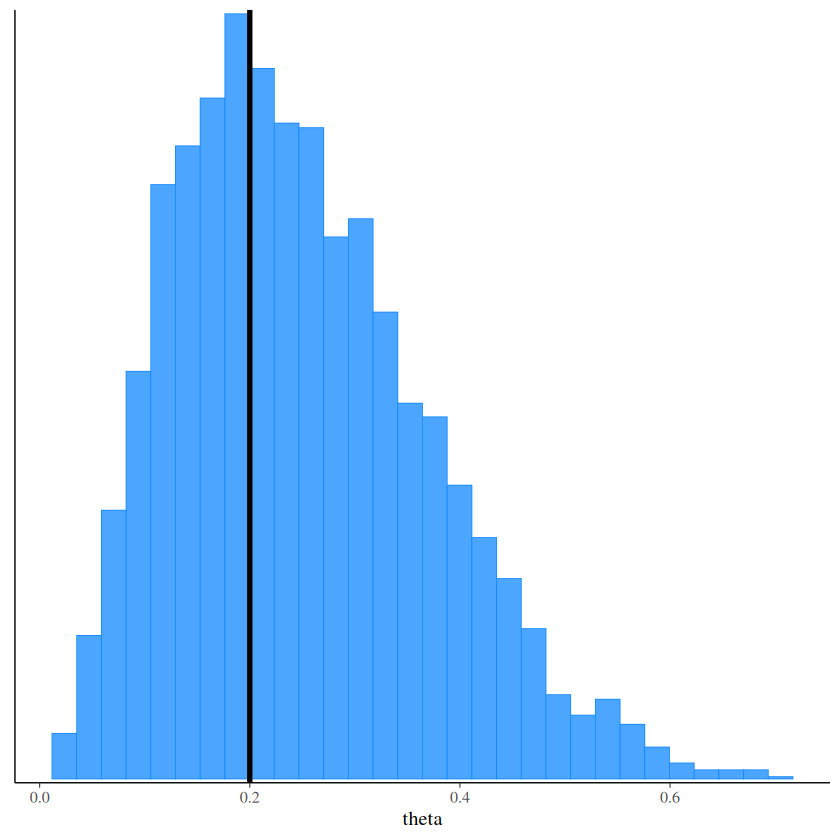

In [24]:
mcmc_hist(fit$draws("theta")) +
  vline_at(fit_mle$mle("theta"), size = 1.5)

### Variational Bayes

We can run Stan's experimental variational Bayes algorithm (ADVI) using the
[`$variational()`](https://mc-stan.org/cmdstanr/reference/model-method-variational.html)
method.

In [25]:
fit_vb <- mod$variational(data = data_list, seed = 123, output_samples = 4000)
fit_vb$summary("theta")

------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3e-06 seconds 
1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100           -6.262             1.000            1.000 
   200           -6.263             0.500            1.000 
   300           -6.307             0.336         

variable,mean,median,sd,mad,q5,q95
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
theta,0.2673525,0.249894,0.1170152,0.1166473,0.1046696,0.4866761


The `$draws()` method can be used to access the approximate posterior draws.
Let's extract the draws, make the same plot we made after MCMC, and compare the
two. In this trivial example the distributions look quite similar, although
the variational approximation slightly underestimates the posterior
standard deviation.

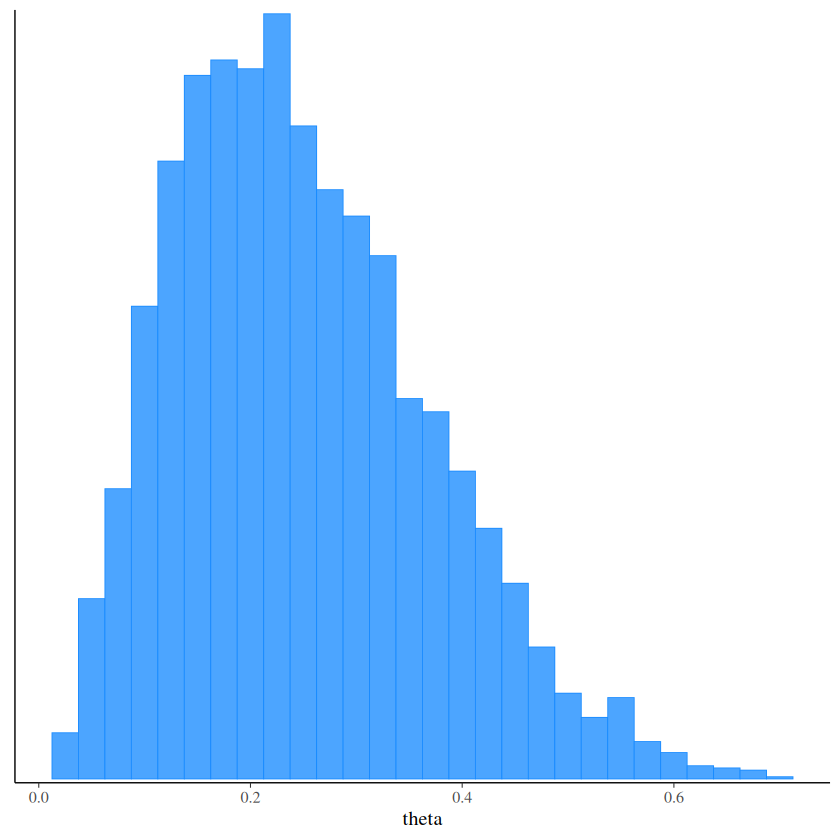

In [26]:
mcmc_hist(fit$draws("theta"), binwidth = 0.025)

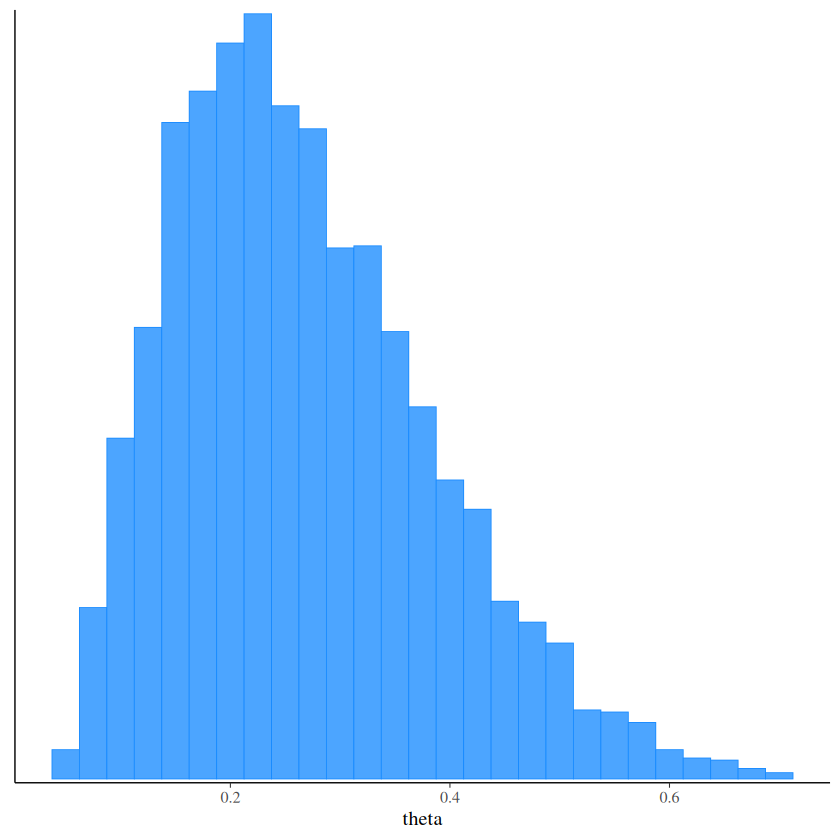

In [27]:
mcmc_hist(fit_vb$draws("theta"), binwidth = 0.025)

For more details on the `$optimize()` and `$variational()` methods, follow
these links to their documentation pages.

* [`$optimize()`](https://mc-stan.org/cmdstanr/reference/model-method-optimize.html)
* [`$variational()`](https://mc-stan.org/cmdstanr/reference/model-method-variational.html)


## Saving fitted model objects

The [`$save_object()`](http://mc-stan.org/cmdstanr/reference/fit-method-save_object.html)
method provided by CmdStanR is the most convenient way to save a fitted model object
to disk and ensure that all of the contents are available when reading the object back into R.

In [28]:
fit$save_object(file = "fit.RDS")

# can be read back in using readRDS
fit2 <- readRDS("fit.RDS")

But if your model object is large, then
[`$save_object()`](http://mc-stan.org/cmdstanr/reference/fit-method-save_object.html)
could take a long time. 
[`$save_object()`](http://mc-stan.org/cmdstanr/reference/fit-method-save_object.html)
reads the CmdStan results files into memory, stores them in the model object,
and saves the object with `saveRDS()`. To speed up the process, you can emulate
[`$save_object()`](http://mc-stan.org/cmdstanr/reference/fit-method-save_object.html)
and replace `saveRDS` with the much faster `qsave()` function from the
[`qs`](https://github.com/traversc/qs) package.

In [ ]:
# Load CmdStan output files into the fitted model object.
fit$draws() # Load posterior draws into the object.
try(fit$sampler_diagnostics(), silent = TRUE) # Load sampler diagnostics.
try(fit$init(), silent = TRUE) # Load user-defined initial values.
try(fit$profiles(), silent = TRUE) # Load profiling samples.

# Save the object to a file.
qs::qsave(x = fit, file = "fit.qs")

# Read the object.
fit2 <- qs::qread("fit.qs")

Storage is even faster if you discard results you do not need to save.
The following example saves only posterior draws and discards
sampler diagnostics, user-specified initial values, and profiling data.

In [ ]:

# Load posterior draws into the fitted model object and omit other output.
fit$draws()

# Save the object to a file.
qs::qsave(x = fit, file = "fit.qs")

# Read the object.
fit2 <- qs::qread("fit.qs")

See the vignette [_How does CmdStanR work?_](http://mc-stan.org/cmdstanr/articles/cmdstanr-internals.html)
for more information about the composition of CmdStanR objects.

## Comparison with RStan



## Additional resources

There are additional vignettes available that discuss other aspects of using
CmdStanR. These can be found online at the CmdStanR website:

* https://mc-stan.org/cmdstanr/articles/index.html

To ask a question please post on the Stan forums:

* https://discourse.mc-stan.org/

To report a bug, suggest a feature (including additions to these vignettes), or to start contributing to CmdStanR
development (new contributors welcome!) please open an issue on GitHub:

* https://github.com/stan-dev/cmdstanr/issues